# Die Stimmungserkennung (SER)

## Inhalt

* [Tensorboard](#Tensorboard)
* [Python-Bibliotheken](#Bibliotheken)
* [Die Vorverarbeitung](#Vorverarbeitung)  
    * [Die Datenbeladung](#Datenbeladung)    
    * [Die Datenvisualisierung](#datenvisual)
* [Das Klassifikationsmodell](#klassifikationsmodell)
    * [Die Modellskonfiguration](#modelskonfiguration)
    * [Die Modellstruktur](#modellstruktur)
    * [Modell-Training](#modelltraining)

## Tensorboard<a class="anchor" id="Tensorboard"></a>

#### Tensorboard ist eine Webanwendung zur Visualisierungverschidener Aspekte neuronaler Netze

## Python-Bibliotheken<a class="anchor" id="Bibliotheken"></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import random
import librosa
import librosa.display
import tensorflow as tf
import torchvision
from torchvision import models, transforms
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import classification_report,confusion_matrix
import itertools
from sklearn.model_selection import StratifiedKFold
from google.colab import drive
import os
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split

In [2]:
writer = SummaryWriter()

## Die Vorverarbeitung<a class="anchor" id="Vorverarbeitung"></a>

In [3]:
# "surprise" wird von 8 auf 0 geändert
EMOTIONS = {0:'neutral', 1:'happy', 2:'sad', 3:'angry', 4:'fear', 5:'surprise'} 
class_names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]

In [4]:
# Die Trainigschleife
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            writer.add_scalar('loss',loss,epoch)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim = 1)[1], targets)#.view(2)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        writer.add_scalar('accuracy', num_correct / num_examples, epoch )
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        
#Die optimale Lernrate finden        
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses        

In [5]:
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
os.chdir('drive/My Drive')
hgdrive_pat = os.getcwd()

In [7]:
PATH_ZU_RAVDESS = Path.cwd() /"frequenzbereich-cv"
PATH_RAVDESS = PATH_ZU_RAVDESS / "train"

In [8]:
path_model = Path.cwd() / "ravdess" / "modell" / "spec_resnet_cross_val.pth"

In [9]:
 PATH_RAVDESS

PosixPath('/content/drive/My Drive/frequenzbereich-cv/train')

### Die Datenbeladung<a class="anchor" id="Datenbeladung"></a>

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix (PyTorch ResNet50 - Modell)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
  #      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

 #   print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
# Das Einlesen der Bilder
class PrecomputedRavdess(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[2].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length

In [12]:
def LoadRavdess():
    ravdess_train = PrecomputedRavdess(PATH_RAVDESS,
                                  img_transforms=transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
    )
    ravdess_loader = torch.utils.data.DataLoader(ravdess_train, 1200, shuffle=True)
    spectogram = torch.utils.data.DataLoader(ravdess_train,64,shuffle=True ) 
    return ravdess_loader,spectogram

In [13]:
def transform(loader,model):
    device = "cpu"
    with torch.no_grad():
        
        for data in loader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
        
            # torch.max is an argmax operation
            _, predicted = torch.max(outputs.data, 1)
            
         
            return labels,predicted


In [14]:
ravdess_loader, spectogram = LoadRavdess()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Labels: tensor([4, 4, 1, 5, 1, 0, 3, 0, 3, 3, 4, 2, 1, 4, 4, 3, 3, 3, 5, 3, 3, 2, 2, 4,
        0, 1, 4, 5, 5, 2, 3, 5, 2, 2, 4, 3, 0, 1, 5, 0, 0, 4, 5, 3, 1, 0, 4, 0,
        2, 5, 0, 4, 0, 1, 2, 0, 1, 0, 4, 5, 4, 5, 3, 4])


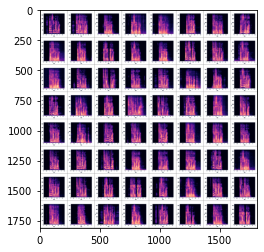

In [15]:
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()
img, label = next(iter(spectogram))      
images, labels = next(iter(ravdess_loader)) 
print("Train Labels:",label) 
imshow(torchvision.utils.make_grid(img)/ 2)

In [16]:
X_dat, X_ost, y_dat, y_ost = train_test_split(images, labels, test_size=0.33, random_state=42) 
loader = torch.utils.data.DataLoader(TensorDataset(X_dat, y_dat),1000,shuffle=True ) # Daten = Trainings + Valid
test_load = torch.utils.data.DataLoader(TensorDataset(X_ost, y_ost),1000,shuffle=True )  # Testdaten
i_train,l_train = next(iter(loader))

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(i_train,l_train, test_size=0.33, random_state=42) 

In [18]:
l_train.shape,y_dat.shape,y_ost.shape 

(torch.Size([281]), torch.Size([281]), torch.Size([139]))

In [19]:
ravdess_train_loader = torch.utils.data.DataLoader(TensorDataset(X_train, y_train),64,shuffle=True ) 
ravdess_valid_loader  = torch.utils.data.DataLoader(TensorDataset(X_valid, y_valid),64,shuffle=True ) 
images_train,labels_train = next(iter(ravdess_train_loader))

In [ ]:
# Cross-validate
kf = StratifiedKFold(5, shuffle=True,random_state=42)

## Das Klassifikationsmodell<a class="anchor" id="#klassifikationsmodell"></a>

### Die Modellskonfiguration<a class="anchor" id="#modelskonfiguration"></a>

In [21]:
def model_res():
    device = "cpu"
    spec_resnet = models.resnet50(pretrained=True)

    for param in spec_resnet.parameters():
        param.requires_grad = False

        spec_resnet.fc = nn.Sequential(nn.Linear(spec_resnet.fc.in_features,500),
                               nn.ReLU(),
                               nn.Dropout(), nn.Linear(500,6))
        return spec_resnet

### Die Modellstruktur<a class="anchor" id="#modellstruktur"></a>

In [ ]:
device = "cpu"
spec_resnet = model_res()
spec_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
grid = torchvision.utils.make_grid(images_train)
writer.add_image("images", grid, 0)
writer.add_graph(spec_resnet, images_train)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Text(0.5, 0, 'Lernrate')

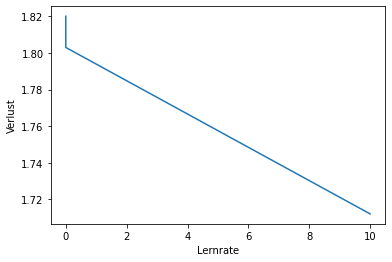

In [ ]:
#Die Lernrate 
spec_resnet.to(device) 
torch.save(spec_resnet.state_dict(), "spec_resnet_cross_val.pth")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(spec_resnet.parameters(), lr=0.001)
logs,losses = find_lr(spec_resnet, loss_fn, optimizer, ravdess_train_loader , device=device)
plt.plot(logs, losses)
plt.ylabel('Verlust')
plt.xlabel('Lernrate')

### Modell-Training<a class="anchor" id="#modelltraining"></a>

In [ ]:
spec_resnet.load_state_dict(torch.load("spec_resnet_cross_val.pth"))

optimizer = optim.Adam(spec_resnet.parameters(), lr=1e-4)
train(spec_resnet, optimizer, nn.CrossEntropyLoss(), ravdess_train_loader, ravdess_valid_loader, epochs = 5, device=device)

for param in spec_resnet.parameters():
    param.requires_grad = True
optimizer = optim.Adam([
                        {'params': spec_resnet.conv1.parameters()},
                        {'params': spec_resnet.bn1.parameters()},
                        {'params': spec_resnet.relu.parameters()},
                        {'params': spec_resnet.maxpool.parameters()},
                        {'params': spec_resnet.layer1.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer2.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer3.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer4.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.avgpool.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.fc.parameters(), 'lr': 1e-4}
                        ], lr=1e-4)

Epoch: 1, Training Loss: 1.79, Validation Loss: 1.84, accuracy = 0.15
Epoch: 2, Training Loss: 1.57, Validation Loss: 1.84, accuracy = 0.15
Epoch: 3, Training Loss: 1.31, Validation Loss: 1.78, accuracy = 0.24
Epoch: 4, Training Loss: 0.99, Validation Loss: 1.68, accuracy = 0.28
Epoch: 5, Training Loss: 0.69, Validation Loss: 1.68, accuracy = 0.30


In [ ]:
fold = 0

for i,y in kf.split(i_train,l_train):
  fold+=1
  print(f"Fold #{fold}")

  x_train = images[i]
  y_train = labels[i]

  x_test = images[y]
  y_test = labels[y]

  data_train = TensorDataset( x_train, y_train )
  ravdess_train_loader = torch.utils.data.DataLoader(data_train,64,shuffle=True )
  
  data_valid = TensorDataset( x_test, y_test )
  ravdess_valid_loader = torch.utils.data.DataLoader(data_valid,64,shuffle=True )

  train(spec_resnet, optimizer, nn.CrossEntropyLoss(), ravdess_train_loader, ravdess_valid_loader,  device=device)

torch.save(spec_resnet.state_dict(),path_model)

Fold #1
Epoch: 1, Training Loss: 0.99, Validation Loss: 0.78, accuracy = 0.79
Epoch: 2, Training Loss: 0.55, Validation Loss: 0.65, accuracy = 0.79
Epoch: 3, Training Loss: 0.29, Validation Loss: 0.73, accuracy = 0.77
Epoch: 4, Training Loss: 0.12, Validation Loss: 0.67, accuracy = 0.81
Epoch: 5, Training Loss: 0.06, Validation Loss: 0.63, accuracy = 0.75
Fold #2
Epoch: 1, Training Loss: 0.19, Validation Loss: 0.02, accuracy = 1.00
Epoch: 2, Training Loss: 0.06, Validation Loss: 0.02, accuracy = 1.00
Epoch: 3, Training Loss: 0.04, Validation Loss: 0.02, accuracy = 1.00
Epoch: 4, Training Loss: 0.02, Validation Loss: 0.03, accuracy = 1.00
Epoch: 5, Training Loss: 0.01, Validation Loss: 0.03, accuracy = 1.00
Fold #3
Epoch: 1, Training Loss: 0.01, Validation Loss: 0.00, accuracy = 1.00
Epoch: 2, Training Loss: 0.01, Validation Loss: 0.00, accuracy = 1.00
Epoch: 3, Training Loss: 0.01, Validation Loss: 0.00, accuracy = 1.00
Epoch: 4, Training Loss: 0.00, Validation Loss: 0.00, accuracy = 1

#### Die Genauigkeit des Modells<a class="anchor" id="Genauigkeit"></a>

#### Metrics

In [22]:
spec_resnet_prod = model_res()
spec_resnet_prod.load_state_dict(torch.load(path_model))  

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


<All keys matched successfully>

### Confusion Matrix (Testdaten)

In [23]:
labels, predicted = transform(test_load,spec_resnet_prod)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       0.96      0.86      0.91        28
           2       0.96      1.00      0.98        24
           3       0.85      0.96      0.90        23
           4       1.00      0.93      0.97        15
           5       1.00      0.96      0.98        28

    accuracy                           0.95       139
   macro avg       0.95      0.95      0.95       139
weighted avg       0.95      0.95      0.95       139

Confusion matrix, without normalization


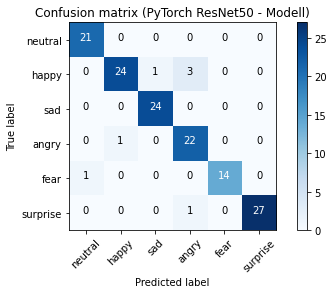

In [24]:
plt.figure()
print(classification_report(labels, predicted))
plot_confusion_matrix(confusion_matrix(labels, predicted), classes=class_names)
plt.show()